## Sequential Convex Programming for Trajectory Generation
- Euler-Lagrange Modeling of 6-DOF Quadrotor dynamics
- Free-final-time and Time-dilation is included

## User input

In [1]:
save_fig = True
fig_format = ['pdf', 'png'][0]
fig_png_dpi = 600

## Libraries

In [2]:
import numpy as np
import cvxpy as cp
import sympy as sp
import time

import os
import glob
import pickle
import warnings
import typing as T
from tqdm import tqdm
from PIL import Image
from itertools import groupby, count

import matplotlib as mpl
from cycler import cycler
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.patches as patches
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

mpl.rcParams['figure.dpi'] = 120 
mpl.rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']}) ## for Palatino and other serif fonts use: #rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.prop_cycle'] = cycler(color=['tab:red', 'k', 'tab:green', 'tab:blue', 'tab:grey'])
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'legend.fontsize': 11})
mpl.rcParams.update({'axes.xmargin': 0})
mpl.rcParams.update({'lines.solid_capstyle': 'round'})
mpl.rcParams.update({'lines.solid_joinstyle': 'round'})
mpl.rcParams.update({'lines.dash_capstyle': 'round'})
mpl.rcParams.update({'lines.dash_joinstyle': 'round'})
mpl.rcParams.update({'text.latex.preamble': r"\usepackage{bm}"})

warnings.filterwarnings("ignore")

## D-GMSR

In [3]:
def gmsr_and(eps : float,
             p : int,
             weights : np.ndarray,
             *args : T.Tuple[T.Any]) -> T.Tuple[T.Any]:
    '''
    Input: The values of the functions and their gradients to be connected with And -> ( f, gf, g, gg, h, gh, ... )
    Output: gmsr_and function's value its gradient -> ( And(f,g,h, ...), And(gf, gg, gh) )
    '''
    
    K = len(args[0])
    fcn_vals = args[0]
    
    pos_idx = list(idx for idx, ele in enumerate(fcn_vals) if ele > 0.)
    neg_idx = list(idx for idx, ele in enumerate(fcn_vals) if ele <=  0.)
    
    pos_vals = fcn_vals[pos_idx]
    neg_vals = fcn_vals[neg_idx]
    
    pos_w = weights[pos_idx]
    neg_w = weights[neg_idx]
    
    sum_w = np.array(weights).sum()

    if neg_idx:
        # If there exits a negative element
        
        # Fcn Val
        sums = 0.
        for idx, neg_val in enumerate(neg_vals):
            sums = sums + neg_w[idx] * (neg_val**(2*p))
        
        Mp = (eps**(p) + (sums / sum_w))**(1/p)
        h_and = eps**(1/2) - Mp**(1/2)
        
        # Grad
        cp = 1/2 * Mp**(-1/2)
        cpm = 2*p / (p * sum_w * Mp**(p-1))
        
        c_i_w_i = np.zeros(K)
        c_i_w_i[neg_idx] = [ cp*cpm*(neg_w[idx] * (np.abs(neg_val))**(2*p-1)) for idx, neg_val in enumerate(neg_vals) ]
            
    else:
        # IF all are positive
        
        # Fcn Val
        mult = 1.
        for idx, pos_val in enumerate(pos_vals):
            mult = mult * ((pos_val)**(2*pos_w[idx]))

        M0 = (eps**(sum_w) + mult)**(1/sum_w)
        h_and = M0**(1/2) - eps**(1/2)
        
        # Grad
        c0 = 1/2 * M0**(-1/2)
        c0m = ( 2 * mult ) / ( sum_w * M0**(sum_w-1) )
                
        c_i_w_i = np.zeros(K)
        c_i_w_i[pos_idx] = [ c0*c0m*(pos_w[idx] / pos_val) for idx, pos_val in enumerate(pos_vals) ]
    
    return h_and, c_i_w_i

def gmsr_or(eps, p, weights, *args):
    '''
    Input: The values of the functions and their gradients to be connected with Or
    Output: gmsr_or function's value its gradient
    '''
    
    args = -args[0]
    h_mor, d_i_w_i = gmsr_and(eps, p, weights, args)
    return -h_mor, d_i_w_i

In [4]:
def UNTIL(eps : float, 
          p : int, 
          w_f : np.ndarray, 
          w_g : np.ndarray,
          w_fg : np.ndarray, 
          f : np.ndarray,
          g : np.ndarray) -> T.Tuple[T.Any]:
    
    s = []
    ds_dg = []
    ds_df = []
    
    K = f.shape[0]
    
    for i in range(K):
        y_i, dyi_dfi = gmsr_and(eps, p, w_f[0:i+1], f[0:i+1])
        s_i, dsi_dyi__dsi_dgi = gmsr_and(eps, p, w_fg[0:2], np.array([y_i, g[i]]))

        dsi_dyi = dsi_dyi__dsi_dgi[0]
        dsi_dgi = dsi_dyi__dsi_dgi[1]
        dsi_dfi = dsi_dyi * dyi_dfi

        s.append(s_i)
        ds_dg.append(dsi_dgi)
        ds_df.append(dsi_dfi)
    
    z, dz_ds = gmsr_or(eps, p, w_g, np.array(s))
    
    dz_df = np.zeros(K)
    for i, dsi_dfi in enumerate(ds_df):
        dz_df[:i+1] += dz_ds[i] * dsi_dfi
    
    dz_dg = dz_ds * np.array(ds_dg)

    return z, dz_df, dz_dg

### Gif maker

In [5]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*"+".png"))][::2]
    frame_one = frames[0]
    frame_one.save(frame_folder+"/"+ "animation.gif", format="GIF", 
                   append_images=frames, save_all=True, duration=0.1, loop=0)

### Print

In [6]:
def dict_append(dict, key, value):
    if key not in dict:
        dict[key] = []
    dict[key].append(value)

    return dict

def print_ite(log_ite_all):

    col_width = int(1 * max(len(ele) for ele in log_ite_all.keys() if ele is not None)) + 4

    if log_ite_all['Note'][-1] == 'First':
        all_dum = ''
        for key in log_ite_all.keys():
            all_dum += key.ljust(col_width)
        print(all_dum)

    all_dum = ''
    for key in log_ite_all.keys():
        if type(log_ite_all[key]) == list:
            dum = log_ite_all[key][-1]
            if isinstance(dum, float):
                dum = round(log_ite_all[key][-1], 2)
                dum = min(dum, 999999.99)

        all_dum += str(dum).ljust(col_width)
    print(all_dum)

### Integration

In [7]:
def rk4(func : T.Any,
        y0 : np.ndarray, 
        tf : float, 
        steps : int, 
        *args : T.Tuple[T.Any]) -> np.ndarray:
    """
    Implementation of the fourth-order Runge-Kutta (RK4) method for numerical integration.

    Parameters:
    - f: Function representing the system of ordinary differential equations (ODEs).
    - y0: Initial conditions (numpy array, n-dimensional column vector).
    - t: Time points for which the solution is calculated.

    Returns:
    - y: Solution of the ODEs at each time point.
    """

    t = np.linspace(0, tf, int(steps))  # Time points

    # Ensure y0 is a NumPy array (n-dimensional column vector)
    # y0 = np.array(y0).reshape(-1, 1)
    y0 = y0.reshape(-1, 1)

    # Initialize solution array
    y = np.zeros((len(t), len(y0)))
    y[0, :] = y0.flatten()

    # Perform RK4 integration
    for i in range(len(t) - 1):

        h = t[i + 1] - t[i]
        k1 = h * func(y[i], t[i], args)
        k2 = h * func(y[i] + 0.5 * k1, t[i] + 0.5 * h, args)
        k3 = h * func(y[i] + 0.5 * k2, t[i] + 0.5 * h, args)
        k4 = h * func(y[i] + k3, t[i] + h, args)

        y[i + 1, :] = y[i, :] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    return y

In [8]:
def dxdt(x : np.ndarray,
         t : float, 
         *args : T.Tuple[T.Any],
        ) -> np.ndarray:

    """
    return: x_dot(t)
    """

    tt, tf, u_0, u_1, params = args[0]
    
    if params['inp_param'] == 'FOH':
        u = u_0 + (t / tf) * (u_1 - u_0)
    elif params['inp_param'] == 'ZOH':
        u = u_0.copy()

    return params['f_func'](x, u)[:, 0]

def integrate_dynamics(x : np.ndarray,
                       u_0 : np.ndarray,
                       u_1 : np.ndarray,
                       params : T.Dict[str, T.Any],
                       tf : float,
                       tt : float,
                      ) -> T.Tuple[np.ndarray]:
    """
    Integration of the vehicle dynamics [0, tf]
    return: x[t+dt] and u
    """
    x_next = rk4(dxdt, x, tf, params['rk4_steps_dyn'], tt, tf, u_0, u_1, params)[-1,:]
    return x_next

def integrate_multiple(X, U, sigma, params):
    
    x_k1_list = []
    for k in range(X.shape[1] - 1):
        if params['free_final_time']:
            if params['time_dil']:
                sigma_k = sigma[0, k]
                tt = np.cumsum(np.concatenate((np.zeros(1), sigma)))[k]
            else:
                sigma_k = sigma / (params['K']-1)
                tt = k * sigma_k
        else:
            sigma_k = params['t_scp']
            tt = k * sigma_k

        x_k1 = integrate_dynamics(X[:, k], U[:, k], U[:, k+1], params, sigma_k, tt)
        x_k1_list.append(x_k1)
        
    return (np.vstack(x_k1_list)).T

### Discretization

In [9]:
def dVdt(V : np.ndarray, 
         t : float, 
         *args : T.Tuple[T.Any],
        ) -> np.ndarray:
    """
    ODE function to compute dVdt.
    V: Evaluation state V = [x, Phi_A, B_bar, C_bar, z_bar]
    t: Evaluation time
    u: Input at start of interval
    return: Derivative at current time and state dVdt
    """

    args = args[0]
    u_0, u_1, sigma, tt, params = args

    n_x = params['n_states']
    n_u = params['n_controls']
    
    i0 = 0
    i1 = n_x
    i2 = i1 + n_x*n_x
    i3 = i2 + n_x*n_u
    i4 = i3 + n_x*n_u
    i5 = i4 + n_x
    i6 = i5 + n_x
    
    x = V[i0:i1]
    p = np.zeros(1)

    if params['inp_param'] == 'ZOH':
        beta = 0.
    elif params['inp_param'] == 'FOH':
        beta = t / params['t_scp']
        if params['free_final_time']:
            if params['time_dil']:
                beta = t
            else:
                beta = (t / (params['K']-1))

    alpha = 1 - beta
    
    u = u_0 + beta * (u_1 - u_0)

    A_subs = sigma * params['A_func'](x, u)
    B_subs = sigma * params['B_func'](x, u)
    f_subs = params['f_func'](x, u)[:, 0]

    # ------------------------------------------------------------------------

    dVdt = np.zeros_like(V)
    dVdt[i0:i1] = sigma * f_subs.T
    dVdt[i1:i2] =  np.matmul(A_subs, V[i1:i2].reshape((n_x, n_x))).reshape(-1)
    dVdt[i2:i3] = (np.matmul(A_subs, V[i2:i3].reshape((n_x, n_u))) + B_subs * alpha).reshape(-1)
    dVdt[i3:i4] = (np.matmul(A_subs, V[i3:i4].reshape((n_x, n_u))) + B_subs * beta).reshape(-1)
    dVdt[i4:i5] = (np.matmul(A_subs, V[i4:i5]).reshape(-1) + np.squeeze(f_subs))

    if params['free_final_time']:
        z_t = - np.matmul(A_subs, x) - np.matmul(B_subs, u)
    else:
        z_t = np.squeeze(f_subs) - np.matmul(A_subs, x) - np.matmul(B_subs, u)
    
    dVdt[i5:i6] = (np.matmul(A_subs, V[i5:i6]).reshape(-1) + z_t)

    # ------------------------------------------------------------------------

    # Phi_A_xi = np.linalg.inv(V[i1:i2].reshape((n_x, n_x)))

    # dVdt = np.zeros_like(V)
    # dVdt[i1:i2] = np.matmul(A_subs, V[i1:i2].reshape((n_x, n_x))).reshape(-1)
    # dVdt[i2:i3] = np.matmul(Phi_A_xi, B_subs).reshape(-1) * alpha
    # dVdt[i3:i4] = np.matmul(Phi_A_xi, B_subs).reshape(-1) * beta
    
    # if params['free_final_time']:
    #     dVdt[i0:i1] = sigma * f_subs.transpose()
    #     dVdt[i4:i5] = np.matmul(Phi_A_xi, f_subs).transpose()
    #     z_t = -np.matmul(A_subs, x) - np.matmul(B_subs, u)
    
    # else:
    #     dVdt[i0:i1] = f_subs.T
    #     z_t = np.squeeze(f_subs) - np.matmul(A_subs, x) - np.matmul(B_subs, u)

    # dVdt[i5:i6] = np.matmul(Phi_A_xi, z_t)

    # ------------------------------------------------------------------------

    return dVdt

def calculate_discretization(X : np.ndarray, 
                             U : np.ndarray, 
                             sigma : np.ndarray, 
                             params : T.Dict[str, T.Any],
                            ) -> T.Dict[str, T.Any]:
    """
    Calculate discretization for given states, inputs and total time.
    X: Matrix of states for all time points
    U: Matrix of inputs for all time points
    return: The discretization matrices
    """
    
    n_x = params['n_states']
    n_u = params['n_controls']
    
    i0 = 0
    i1 = n_x
    i2 = i1 + n_x*n_x
    i3 = i2 + n_x*n_u
    i4 = i3 + n_x*n_u
    i5 = i4 + n_x
    i6 = i5 + n_x
    
    V0 = np.zeros(i6)
    V0[i1:i2] = np.eye(n_x).reshape(-1)

    f_bar = np.zeros((n_x, params['K']-1))
    A_bar = np.zeros((n_x * n_x, params['K']-1))
    B_bar = np.zeros((n_x * n_u, params['K']-1))
    C_bar = np.zeros((n_x * n_u, params['K']-1))
    S_bar = np.zeros((n_x, params['K']-1))
    z_bar = np.zeros((n_x, params['K']-1))

    for k in range(params['K'] - 1):
        V0[i0:i1] = X[:, k]

        if params['free_final_time']:
            if params['time_dil']:
                t_scp = 1
                tt = np.cumsum(np.concatenate((np.zeros(1), sigma)))[k]
                sigma_k = sigma[0,k]
            else:
                t_scp = 1 / (params['K'] - 1)
                tt = k * sigma / (params['K'] - 1)
                sigma_k = sigma
        else:
            t_scp = params['t_scp']
            tt = k * params['t_scp']
            sigma_k = 1

        V = rk4(dVdt, V0, t_scp, params['rk4_steps_J'], U[:, k], U[:, k+1], sigma_k, tt, params)[-1,:]
    
        # flatten matrices in column-major (Fortran) order for cvxpy
        f_bar[:, k] = V[i0:i1]
        # ------------------------------------------------------------------------

        Phi = V[i1:i2].reshape((n_x, n_x))
        A_bar[:, k] = Phi.flatten(order='F')
        B_bar[:, k] = (V[i2:i3].reshape((n_x, n_u))).flatten(order='F')
        C_bar[:, k] = (V[i3:i4].reshape((n_x, n_u))).flatten(order='F')
        S_bar[:, k] = (V[i4:i5])
        z_bar[:, k] = (V[i5:i6])

        # ------------------------------------------------------------------------

        # Phi = V[i1:i2].reshape((n_x, n_x))
        # A_bar[:, k] = Phi.flatten(order='F')
        # B_bar[:, k] = np.matmul(Phi, V[i2:i3].reshape((
        #     n_x, n_u))).flatten(order='F')
        # C_bar[:, k] = np.matmul(Phi, V[i3:i4].reshape((
        #     n_x, n_u))).flatten(order='F')
        # S_bar[:, k] = np.matmul(Phi, V[i4:i5])
        # z_bar[:, k] = np.matmul(Phi, V[i5:i6])

        # ------------------------------------------------------------------------

    params['f_bar'] = f_bar
    params['A_bar'] = A_bar
    params['B_bar'] = B_bar
    params['C_bar'] = C_bar
    params['S_bar'] = S_bar
    params['z_bar'] = z_bar
    
    return params

### Linear / Nonlinear Cost

In [10]:
def scp_non_linear_cost(X_new : np.ndarray,
                        U_new : np.ndarray,
                        sigma_new : np.ndarray,
                        X_last : np.ndarray,
                        U_last : np.ndarray,
                        sigma_last : np.ndarray,
                        nu_new : np.ndarray,
                        nl_nu_new : np.ndarray,
                        w_tr : float,
                        params : T.Dict[str, T.Any],
                        cost_dict : T.Dict[str, T.Any],
                       ) -> T.Tuple[np.ndarray]:
    """
    Returns the nonlinear or linearized cost value of the SCP problem
    Required for prox-linear with adaptive step-size
    """

    dx = X_new - X_last
    du = U_new - U_last
    ds = 0.
    if params['free_final_time']:
        ds = sigma_new - sigma_last
        if params['time_dil']:
            cp_sum = np.linalg.norm(ds, axis=0)**2
        else:
            cp_sum = np.abs(ds)**2
    else:
        cp_sum = 0.

    ptr_cost = w_tr * ( np.linalg.norm(dx, axis=0)**2 + np.linalg.norm(du, axis=0)**2 + cp_sum).sum()

    lcd = params['w_con_dyn'] * np.linalg.norm(nu_new.reshape(-1), 1)
    nlcd = params['w_con_dyn'] * np.linalg.norm(nl_nu_new.reshape(-1), 1)

    lin_vehicle_cost = params['vehicle_cost_fcn'](X_new, U_new, sigma_new, X_last, U_last, sigma_last, params, npy=True)
    n_lin_vehicle_cost, cost_dict = params['vehicle_cost_fcn'](X_new, U_new, sigma_new, X_new, U_new, sigma_new, params, npy=True, cost_dict=cost_dict)
    
    lin_cost = ptr_cost + lcd + lin_vehicle_cost
    n_lin_cost = ptr_cost + nlcd + n_lin_vehicle_cost

    cost_dict = dict_append(cost_dict, 'ptr_cost', ptr_cost)
    cost_dict = dict_append(cost_dict, 'lcd', lcd)
    cost_dict = dict_append(cost_dict, 'nlcd', nlcd)
    
    cost_dict = dict_append(cost_dict, 'lc', lin_cost)
    cost_dict = dict_append(cost_dict, 'nlc', n_lin_cost)

    return cost_dict

### Convex Problem (sub-problem)

In [11]:
def solve_convex_problem(X_last : np.ndarray,
                         U_last : np.ndarray,
                         sigma_last : np.ndarray,
                         w_tr : float,
                         params : T.Dict[str, T.Any],
                        ) -> T.Tuple[np.ndarray]:
       
    """
    Solves the convex sub-problem using ECOS or MOSEK and retruns the optimal values of X and U
    """

    n_x = params['n_states']
    n_u = params['n_controls']

    X  = cp.Variable((n_x, params['K']))
    U  = cp.Variable((n_u, params['K']))
    nu = cp.Variable((n_x, params['K'] - 1))

    dx = X - X_last
    du = U - U_last
    ds = 0.
    
    if params['free_final_time']:
        if (params['time_dil']):
            sigma = cp.Variable((1, params['K'] - 1), nonneg=True)
            ds = sigma - sigma_last
            sig_time = sigma
            cp_sum = cp.sum(cp.norm(ds, axis=0)**2)
        else:
            sigma = cp.Variable(nonneg=True)
            ds = sigma - sigma_last
            sig_time = sigma * np.ones((1, params['K'] - 1))
            cp_sum = cp.sum(cp.abs(ds)**2)

        S_sigma = cp.multiply(params['S_bar'], ( np.ones( (n_x, 1) ) @ sig_time ))
    else:
        cp_sum = 0.
        S_sigma = np.zeros( (n_x, params['K'] - 1) )
        sigma = np.zeros(1)

    cost = w_tr * (cp.sum(cp.norm(dx, axis=0)**2) + cp.sum(cp.norm(du, axis=0)**2) + cp_sum) # Trust region
    cost += params['w_con_dyn'] * cp.sum(cp.abs(nu))

    constraints = [
        X[:, k + 1] ==
        cp.reshape(params['A_bar'][:, k], (n_x, n_x)) @ X[:, k]
        + cp.reshape(params['B_bar'][:, k], (n_x, n_u)) @ U[:, k]
        + cp.reshape(params['C_bar'][:, k], (n_x, n_u)) @ U[:, k+1]
        + S_sigma[:, k]
        + params['z_bar'][:, k]
        + nu[:, k]
        for k in range(params['K'] - 1)
    ]
    
    cost += params['vehicle_cost_fcn'](X, U, sigma, X_last, U_last, sigma_last, params, npy=False)
    constraints += params['vehicle_cons_fcn'](X, U, sigma, X_last, U_last, sigma_last, params, npy=False)
    
    # Create the optimization problem
    problem = cp.Problem(cp.Minimize(cost), constraints)

    # Solve the optimization problem
    try:
        problem.solve(solver='ECOS')
    except:
        problem.solve(solver='MOSEK')

    if params['free_final_time']:
        sigma = sigma.value
    
    return X.value, U.value, sigma, nu.value

### Prox-linear

In [12]:
def prox_linear(params : T.Dict[str, T.Any],
               ) -> T.Dict[str, T.Any]:

    """
    Solves the non-convex trajectory optimization problem using Penalized Trust Region method (PTR)
    """
        
    X_last = params['X_last']
    U_last = params['U_last']
    sigma_last = params['sigma_last']
    w_tr = params['w_ptr']
    last_cost = None
    converged = False

    cost_dict = dict()
    cost_dict = dict_append(cost_dict, 'Ite', 0.)
    cost_dict = dict_append(cost_dict, 'T-Ite', 0.)
    cost_dict = dict_append(cost_dict, 'T-Disc', 0.)
    cost_dict = dict_append(cost_dict, 'T-SubP', 0.)
    
    for ite in range(params['ite']):
        t0_ite = time.time()
        t0_dicr = time.time()
        params = calculate_discretization(X_last, U_last, sigma_last, params)
        t_dicr = time.time() - t0_dicr

        while True:
            
            t0_cvx = time.time()
            X_new, U_new, sigma_new, nu_new = solve_convex_problem(X_last, U_last, sigma_last, w_tr, params)
            t_sub_prob = time.time() - t0_cvx

            X_nl = X_new.copy()
            X_nl[:, 1:] = integrate_multiple(X_new, U_new, sigma_new, params)

            cost_dict = scp_non_linear_cost(X_new, U_new, sigma_new, X_last, U_last, sigma_last, nu_new, (X_new - X_nl),  w_tr, params, cost_dict)
                
            if not(last_cost) or not(params['adaptive_step']):
                X_last = X_new.copy()
                U_last = U_new.copy()
                sigma_last = sigma_new.copy()
                last_cost = cost_dict['nlc'][-1]

                delta_J = '-'
                delta_L = '-'
                rho = '-'
                note = 'First'
                break

            else:
                delta_J = last_cost - cost_dict['nlc'][-1]
                delta_L = last_cost - cost_dict['lc'][-1]

                rho = delta_J / delta_L

                if delta_L < (params['ptr_term']) or (w_tr >= 1e8):
                    converged = True
                    note = 'Conv'
                    break
                
                if rho <= params['r0']:
                    w_tr = w_tr * 2
                    note = 'Rjct'

                    cost_dict = dict_append(cost_dict, 'Ite', (ite + 1))
                    cost_dict = dict_append(cost_dict, 'T-Ite', time.time() - t0_ite)
                    cost_dict = dict_append(cost_dict, 'T-Disc', t_dicr)
                    cost_dict = dict_append(cost_dict, 'T-SubP', t_sub_prob)

                    cost_dict = dict_append(cost_dict, 'D-NL', delta_J)
                    cost_dict = dict_append(cost_dict, 'D-L', delta_L)
                    cost_dict = dict_append(cost_dict, 'Rho', rho)

                    cost_dict = dict_append(cost_dict, 'W-TR', w_tr)
                    cost_dict = dict_append(cost_dict, 'Note', note)

                    print_ite(cost_dict)

                else:
                    X_last = X_new.copy()
                    U_last = U_new.copy()
                    sigma_last = sigma_new.copy()
                    last_cost = cost_dict['nlc'][-1]

                    if rho < params['r1']:
                        w_tr = w_tr * 2.0
                        note = 'Decr'
                    elif params['r2'] <= rho:
                        w_tr = np.maximum(w_tr / 2.0, params['w_ptr_min'])
                        note = 'Incr'
                    else:
                        note = 'Go'
                    break

        if converged:
            print(f'Converged after {ite + 1} iterations.')
            break
        else:
            cost_dict = dict_append(cost_dict, 'Ite', (ite + 1))
            cost_dict = dict_append(cost_dict, 'T-Ite', time.time() - t0_ite)
            cost_dict = dict_append(cost_dict, 'T-Disc', t_dicr)
            cost_dict = dict_append(cost_dict, 'T-SubP', t_sub_prob)

            cost_dict = dict_append(cost_dict, 'D-NL', delta_J)
            cost_dict = dict_append(cost_dict, 'D-L', delta_L)
            cost_dict = dict_append(cost_dict, 'Rho', rho)

            cost_dict = dict_append(cost_dict, 'W-TR', w_tr)
            cost_dict = dict_append(cost_dict, 'Note', note)

            print_ite(cost_dict)

    if not converged:
        print('Maximum number of iterations reached without convergence.')
        
    cost_dict['X_new'] = X_last
    cost_dict['U_new'] = U_last
    cost_dict['sigma_new'] = sigma_new

    return cost_dict

### RUN

In [13]:
def RUN(params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    prox_results = prox_linear(params)

    x_all = [prox_results['X_new'][:,0]]
    u_all = []
    
    x_next = prox_results['X_new'][:,0].copy()
    times = np.arange(0, params['t_f']+params['dt'], params['dt'])
    for i_int in tqdm(range(len(times)-1)):
        params['t_curr'] = times[i_int]

        if params['free_final_time']:
            if params['time_dil']:
                t_cumsum = np.cumsum(prox_results['sigma_new'][0, :])
                idx = np.argwhere(t_cumsum > params['t_curr'])[0,0]
            else:
                idx = int( params['t_curr'] / ( prox_results['sigma_new'] / (params['K'] - 1) ) )
        else:
            idx = int(params['t_curr'] / params['t_scp'])

        if params['inp_param'] == 'ZOH':
            u_0 = prox_results['U_new'][:, idx]
            u_1 = prox_results['U_new'][:, idx]
            
        elif params['inp_param'] == 'FOH':

            if params['free_final_time']:
                if params['time_dil']:
                    t0_scp = (params['t_curr']+1e-6) - t_cumsum[idx]
                    beta_1 =  t0_scp              /prox_results['sigma_new'][0, idx]
                    beta_2 = (t0_scp+params['dt'])/prox_results['sigma_new'][0, idx]
                else:
                    t0_scp = (params['t_curr']+1e-6) % (( prox_results['sigma_new'] / (params['K'] - 1) ))
                    beta_1 =  t0_scp/( prox_results['sigma_new'] / (params['K'] - 1) )
                    beta_2 = (t0_scp+params['dt'])/( prox_results['sigma_new'] / (params['K'] - 1) )
            else:
                t0_scp = (params['t_curr']+1e-6) % (params['t_scp'])
                beta_1 =  t0_scp/params['t_scp']
                beta_2 = (t0_scp+params['dt'])/params['t_scp']

            u_0 = prox_results['U_new'][:, idx] + beta_1 * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
            u_1 = prox_results['U_new'][:, idx] + beta_2 * (prox_results['U_new'][:, idx+1] - prox_results['U_new'][:, idx])
        
        x_next = integrate_dynamics(x_next, u_0, u_1, params, params['dt'], tt=0)

        x_all.append(x_next)
        u_all.append(np.vstack((u_0, u_1)))

    scp_results = dict()
    scp_results['times'] = times

    scp_results['x_all'] = np.vstack(x_all)
    scp_results['u_all'] = np.dstack(u_all)
    scp_results['x_nmpc_all'] = np.dstack(prox_results['X_new'])
    scp_results['u_nmpc_all'] = np.dstack(prox_results['U_new'])

    return scp_results

### Parameters

In [14]:
def qf_params_fcn() -> T.Dict[str, T.Any]:

    """
    Static parameters for the scenario
    """
    
    t_f = 2.0  # Total simulation time [s]
    K = 21 # Total number of nodes
    t_scp = t_f / (K-1)
    free_final_time = False
    time_dil = False

    n_states = 12
    n_controls = 4

    g_0 = 9.806 # Earth's gravity at sea-level [m/s^2] 
    
    # 'rx ry rz vx vy vz phi theta psi p q r'
    x_init  = np.array([ 0.0,  0.0, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    x_final = np.array([ 1.0,  1.0, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

    u_init = np.array([ 0.,  0., 0., g_0])
    u_final = np.array([ 0.,  0., 0., g_0])

    # Quadrotor
    T_max = g_0 * 1.75 # Max thrust [N]
    T_min = g_0 * 0.06 # Min thrust [N]
    tau_max = 0.25

    max_ang = 30 # deg
    max_ang_rate  = 300 # deg / s
    max_ang_rate_yaw  = 100 # deg / s

    # Initialization
    X_last = np.zeros((n_states, K))
    U_last = np.zeros((n_controls, K))
    X_last = np.linspace(x_init, x_final, K).T
    
    U_last[0:3, :] = np.zeros((3, K))
    U_last[3, :] = g_0 

    if time_dil:
        sigma_last = t_scp * np.ones((1, K - 1))
    else:
        sigma_last = t_f

    return dict(
        # ---------------------------------------------------------------------------------------------------

        # General Parameters
        t_f = t_f,
        K = K,
        t_scp = t_scp,
        free_final_time = free_final_time,
        time_dil = time_dil,
        dt = 0.01,

        n_states = n_states,
        n_controls = n_controls,
        inp_param = 'FOH',

        x_init  = x_init,
        x_final = x_final,
        u_init  = u_init,
        u_final = u_final,

        X_last = X_last,
        U_last = U_last,
        sigma_last = sigma_last,

        w_sigma = 1,
        sigma_lb = 0.5,
        add_minmax_sig = False,
        min_sigma = t_scp * 0.1,
        max_sigma = t_scp * 10.,
                
        g_0 = g_0, # Earth's gravity at sea-level [m/s^2] 

        # Quadrotor properties
        vehicle_v_max = 20, # m/s

        I_x = 7e-2, # kg.m^2
        I_y = 7e-2, # kg.m^2
        I_z = 1.27e-1, # kg.m^2

        max_ang = max_ang,
        max_ang_rate = max_ang_rate, 
        max_ang_rate_yaw = max_ang_rate_yaw, 

        phi_bd = np.pi/180 * max_ang,
        theta_bd = np.pi/180 * max_ang,
        phi_rate = np.pi/180 * max_ang_rate, # rad/s^2
        theta_rate = np.pi/180 * max_ang_rate, # rad/s^2
        yaw_rate = np.pi/180 * max_ang_rate_yaw, # rad/s^2

        min_alt = 0., # Min altitude [m]
        
        yaw_fixed = False,
        yaw_fixed_all = False,
        yaw_fx_deg = 0.,

        add_max_alt = False,
        add_min_alt = False,
        w_max_alt = 100.,
        w_min_alt = 0.,

        T_max = T_max, # Max thrust [N]
        T_min = T_min, # Min thrust [N]
        tau_max = tau_max,

        add_inp = False,
        add_inp_trq = False,
        add_elv_rate = False,
        w_inp = 1.,
        w_inp_trq = 1.,
        w_elv_r = 1.,
        
        # ---------------------------------------------------------------------------------------------------

        # Prox-linear Parameters
        ite = 30, # Total number of iterations for the prox-linear algorithm
        w_con_dyn = 1e4, # Penalization weight for the constraints
        
        # Prox-linear via adaptive step-size
        adaptive_step = True, # Updates the penalization cost of prox-linear
        ptr_term = 1e-4, # Termination condition
        # w_ptr = 8, # Initial penaliztion weight for the trust-regrion
        w_ptr = 1, # Initial penaliztion weight for the trust-regrion
        w_ptr_min = 0.001, # Minimum penaliztion weight for the trust-regrion
        r0 = 0.01, # Minimum linearization accuracy to accept the SCP iteration and increase w_ptr
        r1 = 0.1, # Minimum linearization accuracy to use the same w_ptr
        r2 = 0.9, # Minimum linearization accuracy to decrease the w_ptr

        # ---------------------------------------------------------------------------------------------------

        # STL
        stl_eps = 1e-8,
        stl_p = 1,
        stl_w_phi = np.ones(2),
        
        # ---------------------------------------------------------------------------------------------------

        # Integration
        rk4_steps_dyn = 10,
        rk4_steps_J = 10,

        # Scale params
        # TO DO

        # ---------------------------------------------------------------------------------------------------
    )

### Scaling

In [15]:
def scale_params(params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:
    # TO DO
    return params

def unscale_results(results : T.Dict[str, T.Any], params : T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:
    # TO DO
    return results

### Vehcile Dynamics

In [16]:
def fcn_rot():

    with open('rot_mat.pickle', 'rb') as in_f:    
        rot_mat = pickle.loads(in_f.read())

    with open('grad_rot_mat.pickle', 'rb') as in_f:    
        grad_rot_mat = pickle.loads(in_f.read())

    x = sp.Matrix(sp.symbols('phi theta psi', real=True))
    rot_mat_func = sp.lambdify((x,), rot_mat, 'numpy')
    grad_rot_mat_func = sp.lambdify((x,), grad_rot_mat, 'numpy')

    return rot_mat, rot_mat_func, grad_rot_mat_func

In [17]:
def qf_dynamics(params: T.Dict[str, T.Any]) -> T.Dict[str, T.Any]:

    f = sp.zeros(params['n_states'], 1)

    x = sp.Matrix(sp.symbols('x y z vx vy vz phi theta psi p q r', real=True))
    u = sp.Matrix(sp.symbols('ax ay az T', real=True))

    rot, rot_func, grad_rot_func = fcn_rot()

    f[0, 0] = x[3, 0]
    f[1, 0] = x[4, 0]
    f[2, 0] = x[5, 0]

    f[3, 0] = u[3, 0] * rot[2]
    f[4, 0] = u[3, 0] * rot[5]
    f[5, 0] = u[3, 0] * rot[8] - params['g_0']

    # https://sal.aalto.fi/publications/pdf-files/eluu11_public.pdf
    f[6, 0] = x[9, 0] + sp.sin(x[6, 0]) * sp.tan(x[7, 0]) * x[10, 0] + sp.cos(x[6, 0]) * sp.tan(x[7, 0]) * x[11, 0]
    f[7, 0] = sp.cos(x[6, 0]) * x[10, 0] - sp.sin(x[6, 0]) * x[11, 0]
    f[8, 0] = sp.sin(x[6, 0]) / sp.cos(x[7, 0]) * x[10, 0] + sp.cos(x[6, 0]) / sp.cos(x[7, 0]) * x[11, 0]

    f[9 , 0] = (params['I_y'] - params['I_z']) / params['I_x'] * x[10, 0] * x[11, 0] + u[0, 0] / params['I_x']
    f[10, 0] = (params['I_z'] - params['I_x']) / params['I_y'] * x[9, 0]  * x[11, 0] + u[1, 0] / params['I_y']
    f[11, 0] = (params['I_x'] - params['I_y']) / params['I_z'] * x[9, 0]  * x[10, 0] + u[2, 0] / params['I_z']

    f = sp.simplify(f)
    A = sp.simplify(f.jacobian(x))
    B = sp.simplify(f.jacobian(u))

    params['f_func'] = sp.lambdify((x, u), f, 'numpy')
    params['A_func'] = sp.lambdify((x, u), A, 'numpy')
    params['B_func'] = sp.lambdify((x, u), B, 'numpy')

    return params

### Vehicle Constraints

In [18]:
def qf_cost_fcn(X : np.ndarray,
                U : np.ndarray,
                sigma : np.ndarray,
                X_last : np.ndarray,
                U_last : np.ndarray,
                sigma_last : np.ndarray,
                params : T.Dict[str, T.Any],
                npy : bool,
                cost_dict : T.Dict[str, T.Any] = None,
                ) -> T.Tuple[T.Any]:
    # --------------------------------------------------------------------------------------------------------------
    
    vehicle_cost = 0.
    if cost_dict is not None: 
        n_lin_vehicle_cost = 0.

    if params['free_final_time']:
        if params['time_dil']:
            if npy:
                sigma_cost = params['w_sigma'] * np.linalg.norm(sigma[0, :], 1) / params['t_f']
            else:
                sigma_cost = params['w_sigma'] * cp.pnorm(sigma[0, :], 1) / params['t_f']
        else:
            if npy:
                sigma_cost = params['w_sigma'] * sigma / params['t_f']
            else:
                sigma_cost = params['w_sigma'] * cp.pnorm(sigma, 1) / params['t_f']

        vehicle_cost += sigma_cost

        if cost_dict is not None:
            cost_dict = dict_append(cost_dict, 'sigma_cost', sigma_cost)
            n_lin_vehicle_cost += sigma_cost

    # --------------------------------------------------------------------------------------------------------------

    if params['add_inp']:
        if npy:
            input_cost = ( params['w_inp'] * np.sum(np.square(U[3,:])))
            if params['add_inp_trq']:
                input_cost += ( params['w_inp_trq'] * np.sum(np.square(U[0,:])))
                input_cost += ( params['w_inp_trq'] * np.sum(np.square(U[1,:])))
                input_cost += ( params['w_inp_trq'] * np.sum(np.square(U[2,:])))

        else:
            input_cost = ( params['w_inp'] * cp.sum(cp.square(U[3,:])))
            if params['add_inp_trq']:
                input_cost += ( params['w_inp_trq'] * cp.sum(cp.square(U[0,:])))
                input_cost += ( params['w_inp_trq'] * cp.sum(cp.square(U[1,:])))
                input_cost += ( params['w_inp_trq'] * cp.sum(cp.square(U[2,:])))

        vehicle_cost += input_cost

        if cost_dict is not None:
            cost_dict = dict_append(cost_dict, 'input_cost', input_cost)
            n_lin_vehicle_cost += input_cost

    # --------------------------------------------------------------------------------------------------------------
    
    # Dont forget to update linear/nonlinear cost functions
    if params['add_elv_rate']:
        if npy:
            elv_rate_cost = ( params['w_elv_r'] * np.sum(np.square(X[5,:])))
        else:
            elv_rate_cost = ( params['w_elv_r'] * cp.sum(cp.square(X[5,:])))

        vehicle_cost += elv_rate_cost

        if cost_dict is not None:
            cost_dict = dict_append(cost_dict, 'elv_rate_cost', elv_rate_cost)
            n_lin_vehicle_cost += elv_rate_cost

    # --------------------------------------------------------------------------------------------------------------

    if cost_dict is not None:
        return n_lin_vehicle_cost, cost_dict
    else:
        return vehicle_cost

def qf_cons_fcn(X : np.ndarray,
                 U : np.ndarray,
                 sigma : np.ndarray,
                 X_last : np.ndarray,
                 U_last : np.ndarray,
                 sigma_last : np.ndarray,
                 params : T.Dict[str, T.Any],
                 npy : bool,
                 ) -> T.Tuple[T.Any]:
    
    vehicle_cons = []

    # --------------------------------------------------------------------------------------------------------------

    if params['free_final_time']:
        vehicle_cons += [sigma >= params['t_f']-0.1]
        vehicle_cons += [sigma <= params['t_f']+0.1]

        if params['time_dil']:
            if params['add_minmax_sig']:
                sigma_ds = (sigma[0, :] - sigma_last[0, :])
                vehicle_cons += [
                        sigma_ds >= params['min_sigma'] * cp.sum(sigma_ds) / params['K'], 
                        sigma_ds <= params['max_sigma'] * cp.sum(sigma_ds) / params['K'], 
                    ]
            
    # --------------------------------------------------------------------------------------------------------------

    # Quadrotor

    vehicle_cons += [X[0:8, 0] == params['x_init'][0:8]]
    vehicle_cons += [X[0:8, -1] == params['x_final'][0:8]]
    vehicle_cons += [X[9:12, 0] == params['x_init'][9:12]]
    vehicle_cons += [X[9:12, -1] == params['x_final'][9:12]]

    vehicle_cons += [
        U[:, 0] == params['u_init'], # Trust
        U[:, -1] == params['u_final'], # Trust
    ]

    # Maximum altitude:
    vehicle_cons += [X[2, 1:-1] >= params['min_alt']]
    
    if params['add_max_alt']:
        vehicle_cons += [
            X[2, 1:-1] <= params['w_max_alt'],
        ]

    if params['add_min_alt']:
        vehicle_cons += [
            X[2, 1:-1] >= params['w_min_alt'],
        ]

    vehicle_cons += [
        cp.pnorm((X[3:6, :]), p=2, axis=0) <= params['vehicle_v_max'],
    ]

    # Input conditions:
    vehicle_cons += [U[3, :] <= params['T_max']]
    vehicle_cons += [U[3, :] >= params['T_min']]

    vehicle_cons += [
        cp.abs(X[6, :]) <= params['phi_bd'],
        cp.abs(X[7, :]) <= params['theta_bd'],
    ]

    if params['yaw_fixed']:
        if params['yaw_fixed_all']:
            vehicle_cons += [
                X[8, :] == params['yaw_fx_deg'], # first yaw fixed
            ]
        else:
            vehicle_cons += [
                X[8, 0] == params['x_init'][8], # first yaw fixed
                X[8, -1] == params['x_final'][8], # final yaw fixed
            ]
            
    vehicle_cons += [
        cp.abs(X[9, :]) <= params['phi_rate'],
        cp.abs(X[10, :]) <= params['theta_rate'],
        cp.abs(X[11, :]) <= params['yaw_rate'],
    ]

    vehicle_cons += [
        cp.abs(U[0, :]) <= params['tau_max'],
        cp.abs(U[1, :]) <= params['tau_max'],
        cp.abs(U[2, :]) <= params['tau_max'],
    ]

    # --------------------------------------------------------------------------------------------------------------
    
    return vehicle_cons

### Plot

In [19]:
def plt_drone_fcn(ax, center, z_dir, length_drone, head_angle):
    
    def cyl(ax, p0, p1, rad_drone, clr=None, clr2=None):

        # Vector in direction of axis
        v = p1 - p0

        # Find magnitude of vector
        mag = np.linalg.norm(v + 1e-6)

        # Unit vector in direction of axis
        v = v / mag

        # Make some vector not in the same direction as v
        not_v = np.array([1, 0, 0])
        if (v == not_v).all():
            not_v = np.array([0, 1, 0])

        # Make vector perpendicular to v
        n1 = np.cross(v, not_v)
        # normalize n1
        n1 /= np.linalg.norm(n1 + 1e-6)

        # Make unit vector perpendicular to v and n1
        n2 = np.cross(v, n1)

        # Surface ranges over t from 0 to length of axis and 0 to 2*pi
        t = np.linspace(0, mag, 2)
        theta = np.linspace(0, 2 * np.pi, 100)
        rsample = np.linspace(0, rad_drone, 2)

        # Use meshgrid to make 2d arrays
        t, theta2 = np.meshgrid(t, theta)

        rsample, theta = np.meshgrid(rsample, theta)

        # Generate coordinates for surface
        # "Tube"
        X, Y, Z = [p0[i] + v[i] * t + rad_drone * np.sin(theta2) * n1[i] 
                   + rad_drone * np.cos(theta2) * n2[i] for i in [0, 1, 2]]
        # "Bottom"
        X2, Y2, Z2 = [p0[i] + rsample[i] * np.sin(theta) * n1[i] 
                      + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]
        # "Top"
        X3, Y3, Z3 = [p0[i] + v[i]*mag + rsample[i] * np.sin(theta) * n1[i] 
                      + rsample[i] * np.cos(theta) * n2[i] for i in [0, 1, 2]]

        ax.plot_surface(X, Y, Z, color=clr, zorder=9)
        ax.plot_surface(X2, Y2, Z2, color=clr, zorder=9)
        ax.plot_surface(X3, Y3, Z3, color=clr, zorder=9)

        if clr2:
            phi = np.linspace(0,2*np.pi, 50)
            theta = np.linspace(0, np.pi, 25)

            dx = 3 * rad_drone*np.outer(np.cos(phi), np.sin(theta))
            dy = 3 * rad_drone*np.outer(np.sin(phi), np.sin(theta))
            dz = 3 * rad_drone*np.outer(np.ones(np.size(phi)), np.cos(theta))

            ax.plot_surface(p1[0]+dx, p1[1]+dy, p1[2]+dz, 
                            cstride=1, rstride=1, color=clr2, zorder=10)
            ax.plot_surface(p0[0]+dx, p0[1]+dy, p0[2]+dz, 
                            cstride=1, rstride=1, color=clr2, zorder=10)

    # Rodrigues' rotation formula
    def rotate_vec(v, d, alpha):
        ada = v * np.cos(alpha) + np.cross(d, v) * np.sin(alpha) + d * np.dot(d, v) * (1 - np.cos(alpha))
        return ada

    z_dir = z_dir / np.linalg.norm(z_dir + 1e-6)
    rad_drone = length_drone * 0.02

    l1_axis = rotate_vec(head_angle, z_dir, np.pi/4)
    p0 = center - l1_axis * length_drone/2
    p1 = center + l1_axis * length_drone/2

    l2_axis = rotate_vec(l1_axis, z_dir, np.pi/2)
    p2 = center - l2_axis * length_drone/2
    p3 = center + l2_axis * length_drone/2

    # Body
    cyl(ax, p0, p1, rad_drone, clr='black', clr2='yellow')
    cyl(ax, p2, p3, rad_drone, clr='black', clr2='yellow')

    # Head
    p6 = center
    p7 = center + head_angle * length_drone/4
    cyl(ax, p6, p7, rad_drone/1.5, clr='gray')

    p8 = center
    p9 = center + z_dir * length_drone/2
    
    # Trust
    cyl(ax, p8, p9, rad_drone*0.8, clr='red')

In [20]:
def qf_plot(results, params):

    rot_mat, rot_mat_func, grad_rot_mat_func = fcn_rot()

    xy_fs = 15
    scatter_sc = 15
    c_up_lim = 'green'
    c_low_lim = 'purple'
    c_trig = 'red'
    c_plt = 'blue'

    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    
    fig = plt.figure(figsize=(9, 9))
    ax = plt.axes(projection='3d',computed_zorder=False)

    spd_norm = np.linalg.norm(results['x_all'][:,3:6], axis=1)

    points = np.array([results['x_all'][:,0], results['x_all'][:,1], results['x_all'][:,2]]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = Line3DCollection(segments, 
                        cmap=plt.cm.rainbow, 
                        norm=plt.Normalize(0., spd_norm.max()), 
                        array=spd_norm, 
                        lw=3,
                        zorder=-2,
                        )

    ax.add_collection(lc)
    cbar = fig.colorbar(lc, aspect=50, pad=-0.27, shrink=0.75, orientation='horizontal')
    cbar.set_label("Speed [m s$^{-1}$]", fontsize=xy_fs, labelpad=5)

    # Plot the quadrotor
    for k in np.linspace(0, results['x_all'].shape[0]-1, 12, dtype=int):

        z_dir = ((rot_mat_func(results['x_all'][k, 6:9].copy()).reshape(3,3)) @ np.array([[0.], [0.], [1.]]))[:,0]
        head_angle = ((rot_mat_func(results['x_all'][k, 6:9].copy()).reshape(3,3)) @ np.array([[1.], [0.], [0.]]))[:,0]

        plt_drone_fcn(ax = ax,
                      center = results['x_all'][k, 0:3],
                      z_dir = z_dir,
                      length_drone = 0.4,
                      head_angle = head_angle )

    # Plot
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')

    xy_fs = 15
    ax.set_xlabel('$r^x$ [m]', size=xy_fs)
    ax.set_ylabel('$r^y$ [m]', size=xy_fs)
    ax.set_zlabel('$r^z$ [m]', size=xy_fs)

    ax.xaxis.labelpad = 20
    ax.yaxis.labelpad = 11
    ax.zaxis.labelpad = 0.5

    xy_fs = 14
    ax.xaxis.set_tick_params(labelsize=xy_fs)
    ax.yaxis.set_tick_params(labelsize=xy_fs)
    ax.zaxis.set_tick_params(labelsize=xy_fs)
    ax.set_zticks(np.arange(0, 2.5, 0.5))

    ax.set_xlim(-0.2, 10.2)
    ax.set_ylim(-0.2, 10.2)
    ax.set_zlim(-0.2, 2.2)

    ax.view_init(10, 220)
    ax.set_aspect('equal')
    if save_fig: fig.savefig('qf_pos.' + fig_format, bbox_inches='tight', dpi=fig_png_dpi)

    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------------------

    fig, axs = plt.subplots(4, 4, gridspec_kw={'height_ratios': [3, 3, 3, 0.001]}, figsize=(9, 5))

    for ax in axs[-1, :]:
        ax.remove()

    # ---------------------------------------------------------------------------------
    
    axa = axs[0,0]
    x_time = np.dstack((results['times'][:-1], results['times'][1:])).reshape(-1)
    axa.plot(x_time, results['u_all'][:,3,:].reshape(-1, order='F'), c='blue')
    axa.axhline(y=params['T_max'], c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('Thrust, $T$ [N]', fontsize=xy_fs)

    axa = axs[0,1]
    x_time = np.dstack((results['times'][:-1], results['times'][1:])).reshape(-1)
    axa.plot(x_time, results['u_all'][:,0,:].reshape(-1, order='F'), c='blue')
    axa.axhline(y=params['tau_max'], c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$\\tau_x$ [N m]', fontsize=xy_fs)

    axa = axs[0,2]
    x_time = np.dstack((results['times'][:-1], results['times'][1:])).reshape(-1)
    axa.plot(x_time, results['u_all'][:,1,:].reshape(-1, order='F'), c='blue')
    axa.axhline(y=params['tau_max'], c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$\\tau_z$ [N m]', fontsize=xy_fs)

    axa = axs[0,3]
    x_time = np.dstack((results['times'][:-1], results['times'][1:])).reshape(-1)
    axa.plot(x_time, results['u_all'][:,2,:].reshape(-1, order='F'), c='blue')
    axa.axhline(y=params['tau_max'], c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$\\tau_z$ [N m]', fontsize=xy_fs)
    
    # ---------------------------------------------------------------------------------

    axa = axs[1,0]
    spd_norm = np.linalg.norm(results['x_all'][:,3:6], axis=1)
    axa.plot(results['times'], spd_norm, c=c_plt)
    spd_node = np.linalg.norm(results['x_nmpc_all'][0, :, 3:6], axis=1)
    axa.scatter(results['times'][::int(params['t_scp']/params['dt'])], 
                spd_node, s=scatter_sc, c='black')
    # axa.plot([0, params['t_f']], 
    #          [params['vehicle_v_max'], params['vehicle_v_max']], 
    #          c=c_up_lim, linestyle='dashed')
    axa.axhline(y=params['vehicle_v_max'], c=c_up_lim, linestyle='dashed')
    axa.set_xlabel(r'time', fontsize=xy_fs)
    axa.set_ylabel('Speed, $v$ [m/s]', fontsize=xy_fs)

    axa = axs[1,1]
    axa.plot(results['times'], results['x_all'][:,6].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times'][::int(params['t_scp']/params['dt'])], 
                results['x_nmpc_all'][0, :, 6]*180/np.pi, s=scatter_sc, c='black')
    axa.axhline(y=-params['phi_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.axhline(y= params['phi_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$p$ [deg s$^{-2}$]', fontsize=xy_fs)

    axa = axs[1,2]
    axa.plot(results['times'], results['x_all'][:,7].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times'][::int(params['t_scp']/params['dt'])], 
                results['x_nmpc_all'][0, :, 7]*180/np.pi, s=scatter_sc, c='black')
    axa.axhline(y=-params['theta_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.axhline(y= params['theta_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$q$ [deg s$^{-2}$]', fontsize=xy_fs)

    axa = axs[1,3]
    axa.plot(results['times'], results['x_all'][:,8].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times'][::int(params['t_scp']/params['dt'])], 
                results['x_nmpc_all'][0, :, 8]*180/np.pi, s=scatter_sc, c='black')
    axa.axhline(y=-params['yaw_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.axhline(y= params['yaw_rate']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$r$ [deg s$^{-2}$]', fontsize=xy_fs)
    
    # ---------------------------------------------------------------------------------

    axa = axs[2,0]
    axa.plot(results['times'], results['x_all'][:,2], c=c_plt)
    axa.scatter(results['times'][::int(params['t_scp']/params['dt'])], 
                results['x_nmpc_all'][0, :, 2], s=scatter_sc, c='black')
    axa.axhline(y=params['min_alt'], c=c_up_lim, linestyle='dashed')
    if params['add_max_alt']:
        axa.axhline(y=params['w_max_alt'], c='purple', linestyle='dashed')
    if params['add_min_alt']:
        axa.axhline(y=params['w_min_alt'], c='purple', linestyle='dashed')
    axa.set_xlabel(r'time', fontsize=xy_fs)
    axa.set_ylabel('Altitude, $z$ [m]', fontsize=xy_fs)

    axa = axs[2,1]
    axa.plot(results['times'], results['x_all'][:,6].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times'][::int(params['t_scp']/params['dt'])], 
                results['x_nmpc_all'][0, :, 6]*180/np.pi, s=scatter_sc, c='black')
    axa.axhline(y=-params['phi_bd']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.axhline(y= params['phi_bd']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$\\phi$ [deg]', fontsize=xy_fs)

    axa = axs[2,2]
    axa.plot(results['times'], results['x_all'][:,7].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times'][::int(params['t_scp']/params['dt'])], 
                results['x_nmpc_all'][0, :, 7]*180/np.pi, s=scatter_sc, c='black')
    axa.axhline(y=-params['theta_bd']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.axhline(y= params['theta_bd']*180/np.pi, c=c_up_lim, linestyle='dashed')
    axa.set_ylabel('$\\theta$ [deg]', fontsize=xy_fs)

    axa = axs[2,3]
    axa.plot(results['times'], results['x_all'][:,8].reshape(-1, order='F')*180/np.pi, c='blue')
    axa.scatter(results['times'][::int(params['t_scp']/params['dt'])], 
                results['x_nmpc_all'][0, :, 8]*180/np.pi, s=scatter_sc, c='black')
    axa.set_ylabel('$\\psi$ [deg]', fontsize=xy_fs)

    # ---------------------------------------------------------------------------------

    lines_labels = [axs.get_legend_handles_labels() for axs in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels, loc = (0.262,0.006), ncol=6, fontsize=15)#, mode = "expand")
    
    if save_fig: fig.savefig('qf_oth.' + fig_format, bbox_inches='tight', dpi=fig_png_dpi)

### Autonomous Rocket Landing

In [21]:
qf_params = qf_params_fcn()
qf_params_sc = scale_params(qf_params.copy())

qf_params_sc = qf_dynamics(qf_params_sc.copy())
qf_params_sc['vehicle_cost_fcn'] = qf_cost_fcn
qf_params_sc['vehicle_cons_fcn'] = qf_cons_fcn

qf_results_sc = RUN(qf_params_sc.copy())
qf_results = unscale_results(qf_results_sc.copy(), qf_params.copy())

Ite         T-Ite       T-Disc      T-SubP      ptr_cost    lcd         nlcd        lc          nlc         D-NL        D-L         Rho         W-TR        Note        
1           0.16        0.08        0.06        30.74       0.0         5961.67     30.74       5992.42     -           -           -           1           First       
2           0.16        0.08        0.06        0.83        0.0         15.8        0.83        16.63       5975.78     5991.59     1.0         0.5         Incr        
3           0.16        0.08        0.06        0.0         0.0         0.0         0.0         0.0         16.63       16.63       1.0         0.25        Incr        
4           0.16        0.08        0.06        0.0         0.0         0.0         0.0         0.0         0.0         0.0         1.0         0.12        Incr        
Converged after 5 iterations.


100%|██████████| 200/200 [00:00<00:00, 792.14it/s]


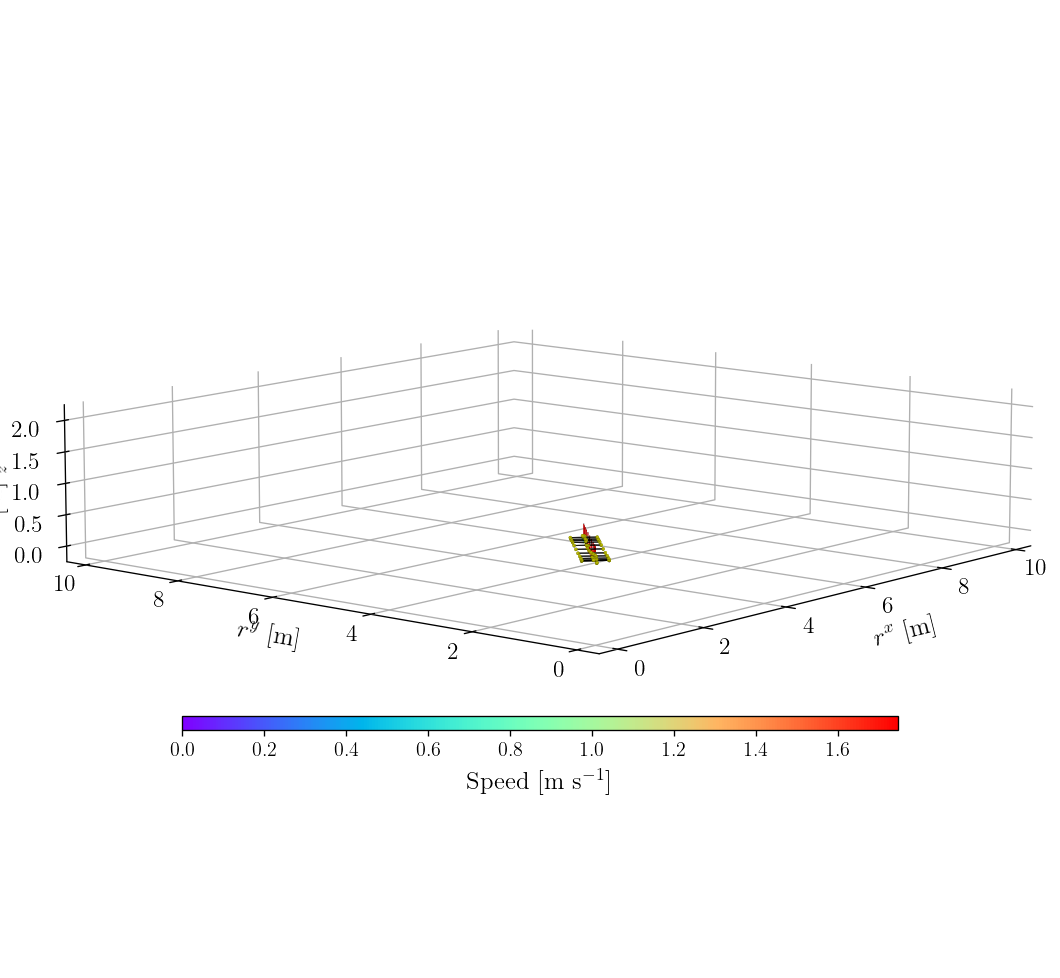

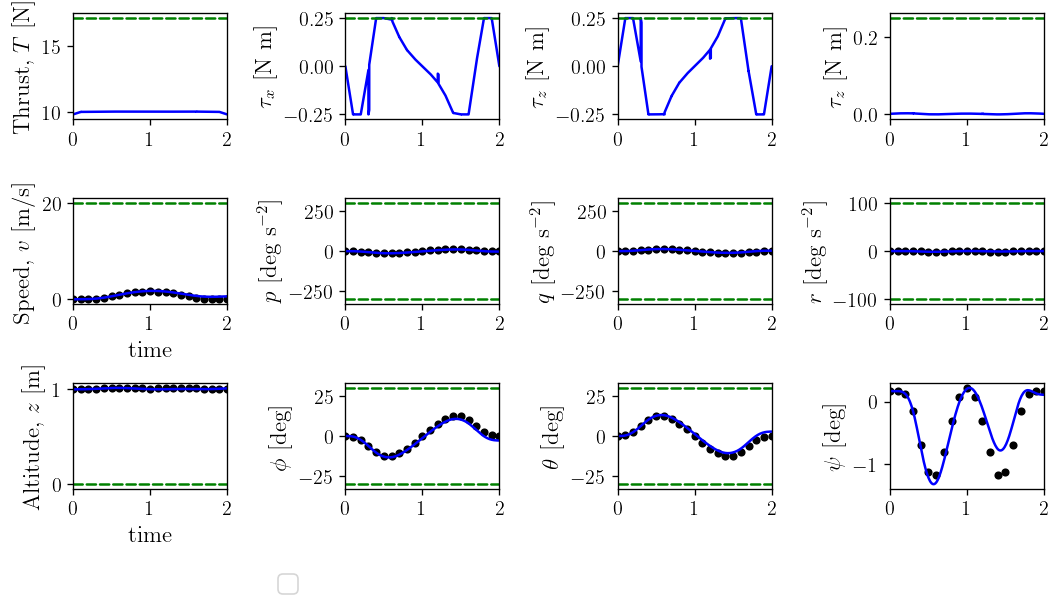

In [22]:
qf_plot(qf_results, qf_params)